In [2]:
%load_ext autoreload
%autoreload 2

# Standard libraries
import os
import numpy as np
import pandas as pd
from math import ceil
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc
from pyspark import StorageLevel
import seaborn as sns




#Import all functions (improve readibility)
from Functions import *

# PySpark core
from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import IntegerType

# PySpark functions
from pyspark.sql.functions import (
    coalesce,
    col, lit, expr, when, count, sum as spark_sum, abs as spark_abs,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg,
    first, last, lag, row_number, desc, asc,
    explode, sequence, from_unixtime, to_date, unix_timestamp,
    window, min_by, mode, concat, monotonically_increasing_id
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 
           'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 
           'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 
           'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 
           'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 
           'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 
           'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 
           'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
alarms = ['A5', 'A9', 'ComError']
engines = ["S117", "S118", "S169", "S170"]
list_hw = ['SW-088']


frequency = 60
nCores = [1]
nPartitions = [1]
nExecutors = [2, 4, 6, 8] 
MEMexec = "2200m" 

loops = [1, 2]
for loop in loops:
    OptimizationResults = {}
    for core in nCores:
        for partition in nPartitions:
    
            clear_output(wait=True)
    
            #----------------------CREATING DATAFRAME --------------------------
            
            TimeResults = {}
            
            #Create spark session
            print(f'Creating Spark session for {(core, partition)}')
            spark = CreateSparkSession(core, partition, 4, MEMexec, log = False)
    
            print('Reading the CSV...')
            startTime = time.time()
            df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv")
    
            #Convert milliseconds into seconds
            df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))
            df.count()
            endTime = time.time()
    
            TimeResults['LoadCSV'] = endTime - startTime
            print('Load CSV time: ', np.round(endTime - startTime, 2), ' seconds')
    
    
            #----------------------PREPROCESSING PIPELINE--------------------------
    
            
            print('Pivot dataset...')
    
            startTime = time.time()
            df = df.filter(col('hwid') == 'SW-088')
            df = df.repartition(partition)
            df_all_hw = (df.groupBy("when")
                       .pivot("metric")
                       .agg(first("value"))
                       .withColumn("time", from_unixtime(col("when")))
                       .orderBy("when"))
    
            print('Persist the dataframe...')
                                        #Save in memory if there is enough, otherwise on disk
            df_all_hw = df_all_hw.persist()
            df_all_hw.count()
            
            endTime = time.time()
    
            TimeResults['Pivot'] = endTime - startTime
            print('Pivot time: ', np.round(endTime - startTime, 2), ' seconds')
    
            
            # Fill sensor gaps and build blocks of independent measurement
            print('Starting preprocessing...')
            
            startTime = time.time()
            #Create grid, homogeneous data
            df_grid = CreateGrid(df_all_hw, interval=frequency)
    
            #Build independent blocks
            df_blocks = BuildBlocks(df_grid, max_interval = 1800, sensors = sensors )
    
            #Fill the NULL values
            df_blocks = FillNull(df_blocks, sensors + engines, max_gap=240)
            
            df_blocks = df_blocks.persist()
            df_blocks.count()
            
            endTime = time.time()
    
            TimeResults['Preprocessing'] = endTime - startTime
    
            print('Preprocessing time: ', np.round(endTime - startTime, 2), ' seconds')
    
            df_all_hw.unpersist()
    
            #----------------------ANOMALY DETECTION--------------------------
    
            useless_sensors, useful_sensors = UsefulSensors(df_blocks, sensors)
    
            #Compute the anomalies for all the hardware sequentially (parallelized internally)
            print('Starting Anomaly detection...')
            startTime = time.time()
    
            df_anomalies = detect_anomalies(df = df_blocks, time_separator = 60*40, threshold = 8, sensors = engines, partition = partition).persist()
            df_anomalies.count()
    
            endTime = time.time()
    
            TimeResults['AnomalyDetection'] = endTime - startTime
    
            print('Anomaly detection time: ', np.round(endTime - startTime, 2), ' seconds')
    
            #------------------------CORRELATIONS--------------------------
            print('Starting computing Correlations...')
    
            startTime = time.time()
    
            df_blocks = spark.createDataFrame(df_blocks.rdd, df_blocks.schema)
            df_anomalies = spark.createDataFrame(df_anomalies.rdd, df_anomalies.schema)
            
            joined_df = df_blocks.join(df_anomalies, on =['when', *engines, 'BlockID'], how='left').persist()
            joined_df.count()
    
            
            anomaly_corr = correlations(joined_df, useful_sensors, 'flag_anomaly')
                
            endTime = time.time()
    
            TimeResults['Correlations'] = endTime - startTime
            print('Correlation time: ', np.round(endTime - startTime, 2), ' seconds')
    
    
            #------------------------PREDICTIVE MAINTEINANCE--------------------------
    
            print('Starting Predictive Mainteinance...')
            startTime1 = time.time()
    
            df_alarms = extract_alarms(df_blocks.select("when","A5","A9"), columns=["A5", "A9"], bits=[6, 7, 8] ).persist()
            df_alarms.count()
    
            endTime1 = time.time()
            
            list_df_final = {}
            
            df_final = joined_df.join(df_alarms.select('when', 'overheating') , on=['when'], how='left' )
    
            startTime2 = time.time()
            
            #Computing correlations
            alarm_corr = correlations(df_final, useful_sensors, 'overheating')
    
            #Computing the predictive dataframe on overheating signals
            target = "overheating"
            df_final088 = add_predictive(df_final, target, window_before_heating=30, debug=False, join=True, partition = partition )
            df_final088.count()
    
            endTime2 = time.time()
    
            TimeResults['Predictive Maintenance'] = (endTime1 - startTime1) + (endTime2 - startTime2)
            print('Predictive Maintenance time: ', np.round((endTime1 - startTime1) + (endTime2 - startTime2), 2), ' seconds')
    
            #-----------------------------------Saving the results 
            
            OptimizationResults[(core, partition)] = TimeResults
    
            data = []
            for (cores, partition), metrics in OptimizationResults.items():
                row = {'Resources': (cores, partition)}
                row.update(metrics)
                data.append(row)
            
            df_alt = pd.DataFrame(data)
            df_alt.to_pickle(f'SingleCore_{loop}.pkl')
    
            #-----------------------------------Clean up the memory
    
            try:
                df_blocks.unpersist()
                df_anomalies.unpersist()
                df_alarms.unpersist()
                
                
                #Garbage collection
                gc.collect()
                
                #Clear Spark cache
                spark.catalog.clearCache()
                
            except Exception as cleanup_error:
                print(f"Cleanup error: {cleanup_error}")
    
            spark.stop()
            time.sleep(5)    

In [4]:
#Multicores results

nCores = [2, 4, 8, 12, 16]
nPartitions = [2, 8, 16, 32, 64, 256]


OptRes_1 = pd.read_pickle('OptRes_4_final.pkl')
OptRes_2 = pd.read_pickle('OptRes_5_final.pkl')

res = OptRes_1.columns.tolist()[0]
col = OptRes_1.columns.tolist()[1:]

AvgDF = 1/2*(OptRes_1.drop(columns = ['Resources']) + OptRes_2.drop(columns = ['Resources']))

#Single core results
SingleCore_1 = pd.read_pickle('SingleCore_1.pkl')
SingleCore_2 = pd.read_pickle('SingleCore_2.pkl')


SingleCoreAvgDF = 1/2*(SingleCore_1.drop(columns = ['Resources']) + SingleCore_2.drop(columns = ['Resources']))
SingleCoreAvgDF['TotalTime'] = SingleCoreAvgDF.sum(axis = 1)


AvgDF['TotalTime'] = AvgDF.sum(axis = 1)
AvgDF

,LoadCSV,Pivot,Preprocessing,AnomalyDetection,Correlations,Predictive Maintenance,TotalTime
0,90.646651,222.673698,49.784269,38.997471,28.130533,13.423296,443.655918
1,86.611090,197.439206,49.679958,40.115889,32.056484,17.366868,423.269494
2,84.104526,205.492570,55.559282,41.690589,34.433692,22.128318,443.408977
3,83.727515,199.984651,62.199333,43.800964,41.397028,27.605399,458.714891
4,83.657842,204.623500,79.406103,47.478699,55.620756,42.413684,513.200584
5,85.192249,212.080930,172.772572,67.212625,121.197286,112.725095,771.180755
6,45.167739,155.021487,47.836552,38.055386,26.800717,12.152054,325.033936
7,44.924157,105.771447,45.713060,38.819443,28.933490,16.205267,280.366864
8,46.687259,107.772933,48.696637,40.604534,32.383260,19.623608,295.768231
9,45.148240,107.666934,54.675280,42.217833,33.897052,24.147771,307.753109


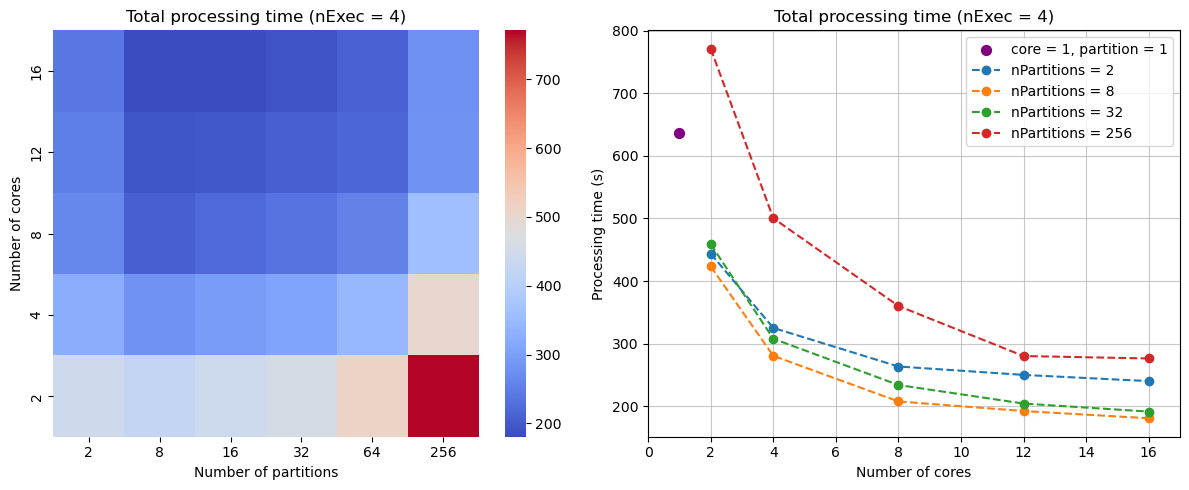

In [5]:
TotalTime = np.reshape(AvgDF['TotalTime'], (5, 6))


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap on the first subplot
sns.heatmap(TotalTime, cmap="coolwarm", ax=ax[0])
ax[0].set_xticklabels(nPartitions)
ax[0].set_yticklabels(nCores)
ax[0].invert_yaxis()
ax[0].set_xlabel('Number of partitions')
ax[0].set_ylabel('Number of cores')
ax[0].set_title("Total processing time (nExec = 4)")

# Line plot on the second subplot

ax[1].scatter(1, SingleCoreAvgDF['TotalTime'], label='core = 1, partition = 1', c = 'purple', s = 50)
for i in [0, 1, 3, 5]:
    ax[1].plot(nCores, TotalTime[:, i], label=f'nPartitions = {nPartitions[i]}', linestyle='--', marker='o')


ax[1].set_xlim(0, 17)
ax[1].grid(True, alpha=0.7)
ax[1].set_xlabel('Number of cores')
ax[1].set_ylabel('Processing time (s)')
ax[1].set_title("Total processing time (nExec = 4)")
ax[1].legend()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Process time (s)')

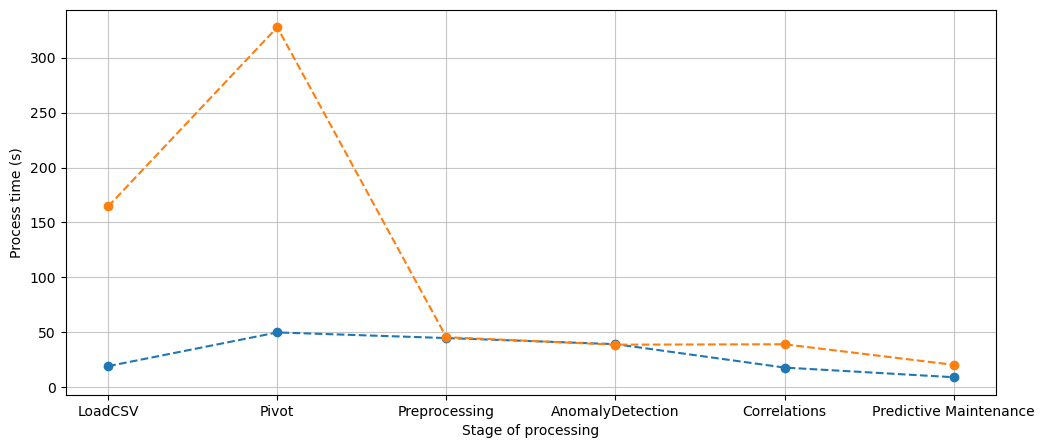

In [8]:
bestMultiCores = AvgDF.iloc[np.argmin(AvgDF['TotalTime'])][:-1]
#Comparison between single core and best multicore result:



SingleCoreTT = SingleCoreAvgDF.iloc[0][:-1]

bestMultiCores = AvgDF.iloc[np.argmin(AvgDF['TotalTime'])][:-1]


plt.figure(figsize = (12, 5))
plt.plot(col, bestMultiCores, label=f'{res[0]} cores, {res[1]} partitions', linestyle='--', marker = 'o')
plt.plot(col, SingleCoreTT, label='1 core, 1 partition', linestyle='--', marker = 'o')
plt.grid(True, alpha = 0.7)
plt.xlabel('Stage of processing')
plt.ylabel('Process time (s)')